# 1 Setup

### Import Libraries

In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

### Initialize Default Style Parameters

In [2]:
plt.rcParams['figure.figsize'] = (6,6)

### Define Helper Functions

In [3]:
# Helper function for resizing colorbar
def geopandas_colorbar_same_height(f, ax, vmin, vmax, cmap):
    from matplotlib.colors import Normalize
    from matplotlib import cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)

    norm = Normalize(vmin=vmin, vmax=vmax)
    n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    n_cmap.set_array([])

    cbar = f.colorbar(n_cmap, cax=cax)
    return cbar

# 2 Import Data

In [4]:
# Import shapefile
gdf = gp.GeoDataFrame.from_file('DistritosEODHogaresZMVM2017/DistritosEODHogaresZMVM2017.shp')
# Convert to EPSG:4326
gdf.to_crs(epsg=4326, inplace=True)

In [5]:
# Create columns for integer-form district number and for the district area
gdf['Distrito_int'] = gdf['Distrito'].apply(int)

## Trip Attraction

In [6]:
dictionary = pd.read_csv('eod_2017_csv/tviaje_eod2017/diccionario_de_datos_en/diccionario_datos_tviaje.csv')
dictionary.head()

,field_name,length,type,mnemonic,catalogue,key_ranges
0,Travel identifier,6,N,id_via,NaN,1-531594
1,Person identifier,6,N,id_soc,NaN,1-200117
2,Question 5.3 Classification of the day of travel,1,C,p5_3,p5_3,"1,2"
3,Question 5.8 travel number,2,C,n_via,NaN,01-14
4,Question 5.6 What kind of place is the origin ...,2,C,p5_6,p5_6,"01-16,99"


In [7]:
data = pd.read_csv('eod_2017_csv/tviaje_eod2017/conjunto_de_datos/tviaje.csv')
data.head()

,id_via,id_soc,p5_3,n_via,p5_6,p5_7_6,p5_7_7,dto_origen,p5_9_1,p5_9_2,...,p5_27_6,p5_27_7,p5_27_8,estrato,factor,upm_dis,est_dis,tloc,sexo,edad
0,2936,1268,1,1,1,15,9,2,8,0,...,NaN,NaN,NaN,3,244,87,40,1,2,26
1,2937,1268,1,2,3,16,9,16,14,0,...,NaN,NaN,NaN,3,244,87,40,1,2,26
2,2938,1268,2,1,1,15,9,2,17,0,...,NaN,NaN,NaN,3,244,87,40,1,2,26
3,2939,1268,2,2,7,15,9,2,23,0,...,NaN,NaN,NaN,3,244,87,40,1,2,26
4,2940,1269,1,1,1,15,9,2,8,0,...,NaN,NaN,NaN,3,244,87,40,1,2,22


In [8]:
# Count the number of occurrences where each district is a trip destination
dest_sum = data['dto_dest'].value_counts().to_frame()

# Merge with the GDF, normalize to area
gdf_dest = pd.merge(gdf,dest_sum,left_on='Distrito_int',right_index=True)
gdf_dest.head()

,Distrito,Descripcio,geometry,Distrito_int,dto_dest
0,001,Centro HistÃ³rico,POLYGON ((-99.13615639445072 19.44077855087982...,1,9718
1,002,Buenavista-Reforma,"POLYGON ((-99.1428980497852 19.46364494054671,...",2,5177
2,003,Tlatelolco,POLYGON ((-99.13141865172925 19.46378321641288...,3,2861
3,004,Morelos,POLYGON ((-99.10946106140032 19.45291794602026...,4,3746
4,005,"Moctezuma, Terminal de Autobuses de Oriente (T...",POLYGON ((-99.10055671090755 19.44982753391222...,5,2903


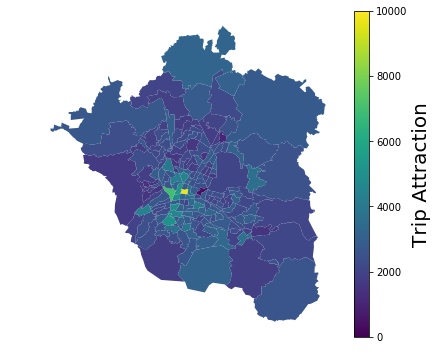

In [9]:
# Visualize Trip Attraction
vmin = 0
vmax = 10000
cmap = plt.cm.get_cmap('viridis')

fig,ax = plt.subplots()
gdf_dest.plot(column='dto_dest',cmap=cmap,ax=ax,vmin=vmin,vmax=vmax)
cbar = geopandas_colorbar_same_height(fig,ax,vmin,vmax,cmap)
cbar.ax.set_ylabel('Trip Attraction', fontsize=20)
ax.axis('off')
plt.savefig('fig1a.svg')
plt.show()

## Including Socio-Demographic Information

In [10]:
sdem_data = pd.read_csv('eod_2017_csv/tsdem_eod2017/conjunto_de_datos/tsdem.csv')
sdem_data.head()

,id_soc,id_hog,n_ren,parentesco,sexo,edad,niv,gra,p3_7,p3_8,...,p5_4,p6_4,estrato,factor,upm_dis,est_dis,tloc,distrito,ent,mun
0,2655,920,1,1,1,47,3.0,3.0,1.0,NaN,...,NaN,1.0,2,103,195,80,1,4,9,17
1,2656,920,2,2,2,33,6.0,3.0,5.0,4.0,...,4.0,1.0,2,103,195,80,1,4,9,17
2,2657,920,3,5,1,64,2.0,6.0,1.0,NaN,...,NaN,1.0,2,103,195,80,1,4,9,17
3,2658,920,4,3,1,11,2.0,5.0,NaN,NaN,...,2.0,1.0,2,103,195,80,1,4,9,17
4,2659,920,5,3,1,7,2.0,1.0,NaN,NaN,...,2.0,1.0,2,103,195,80,1,4,9,17


In [11]:
# District Population
gdf_dest = pd.merge(gdf_dest,
                    sdem_data.groupby(by='distrito').sum()['factor'],
                    how='outer',
                    left_on='Distrito_int',
                    right_index=True)

# District Weighted Socio-Economic Stratum
gdf_dest = pd.merge(gdf_dest,
                    sdem_data.groupby(by='distrito').agg(lambda x: np.average(x,weights=sdem_data.loc[x.index,'factor']))['estrato'],
                    how='outer',
                    left_on='Distrito_int',
                    right_index=True)
# Note: District 34 has NaN population and stratum as it is the airport

gdf_dest = gdf_dest.rename({'factor':'population','estrato':'sd_strat'},axis='columns',copy=False)

## Places of Interest

In [12]:
pub_com_dict = {'public':['dentist','doctor','fire_station','hospital','library','pharmacy','police',
                          'post_office','physiotherapist','school','church','cemetery','hindu_temple',
                          'mosque','synagogue','city_hall','courthouse','embassy','local_government_office','airport',
                          'bus_station','subway_station','taxi_stand','train_station','transit_station','gas_station',
                          'parking'],
                'commercial':['electrician','funeral_home','lawyer','laundry','locksmith','moving_company','painter',
                              'plumber','real_estate_agency','roofing_contractor','travel_agency','veterinary_care',
                              'storage','rv_park','beauty_salon','bicycle_store','book_store','car_dealer',
                              'car_rental','car_repair','car_wash','clothing_store','convenience_store',
                              'department_store','electronics_store','florist','furniture_store','hair_care',
                              'hardware_store','home_goods_store','jewelry_store','liquor_store','gym','movie_rental',
                              'movie_theater','pet_store','shoe_store','shopping_mall','store','amusement_park',
                              'art_gallery','aquarium','bowling_alley','campground','casino','museum','park','spa',
                              'stadium','zoo','bakery','bar','cafe','night_club','meal_delivery','meal_takeaway',
                              'restaurant','supermarket','lodging','accounting','atm','bank','insurance_agency']}

In [13]:
# Intialize for later use
gdf_dest['dto_poi'] = np.zeros(len(gdf));
gdf_dest['dto_poi_pub'] = np.zeros(len(gdf));
poi_df = pd.DataFrame(columns=['name','place_id','types','lat','lng','category'])

# For each district - Note: data was collected on a district-by-district basis
for i in range(len(gdf)):
    
    # Collect data from json files for ith district
    places=[];
    for file in glob.glob("data_mexico/data{}/*.json".format(i)):
        with open(file) as f:
            data=json.load(f)
        for k in data:
            places.append(data[k])
    
    # Create local dataframe for easy management
    places_df = pd.DataFrame(data=places,columns=['geometry','name','place_id','types'])
    
    # Clean up data, only keep establishments (not political label), remove duplicates
    places_df = places_df[['establishment' in places_df['types'][j] for j in range(len(places_df))]]
    places_df = places_df.drop_duplicates(subset=['place_id']).reset_index(drop=True)
    
    # Extract and explicitly store lat and lng per POI (which were embedded in 'geometry')
    places_df['lat'] = [places_df['geometry'][j]['location']['lat'] for j in range(len(places_df))]
    places_df['lng'] = [places_df['geometry'][j]['location']['lng'] for j in range(len(places_df))]
    places_df = places_df.drop(columns=['geometry'])
    
    # Record what district the POI is in
    places_df['district'] = i+1
    
    # Categorize establishment type
    places_df['category'] = ['public' if not set(pub_com_dict['public']).isdisjoint(places_df['types'][j]) else 'commercial' for j in range(len(places_df))]
    
    # Store Number of POI per District
    gdf_dest['dto_poi'][i] = len(places_df) # Drop duplicates
    gdf_dest['dto_poi_pub'][i] = len(places_df[places_df['category'] == 'public'])
    
    # Store all POIs in a DataFrame
    poi_df = pd.concat([poi_df,places_df],sort=True).drop_duplicates(subset=['place_id']).reset_index(drop=True)
    
    print('Processing District', i+1, '/', len(gdf), '...')
    
gdf_dest['dto_poi_com'] = gdf_dest['dto_poi'] - gdf_dest['dto_poi_pub']
print('Done!')

/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Processing District 1 / 194 ...
Processing District 2 / 194 ...
Processing District 3 / 194 ...
Processing District 4 / 194 ...
Processing District 5 / 194 ...
Processing District 6 / 194 ...
Processing District 7 / 194 ...
Processing District 8 / 194 ...
Processing District 9 / 194 ...
Processing District 10 / 194 ...
Processing District 11 / 194 ...
Processing District 12 / 194 ...
Processing District 13 / 194 ...
Processing District 14 / 194 ...
Processing District 15 / 194 ...
Processing District 16 / 194 ...
Processing District 17 / 194 ...
Processing District 18 / 194 ...
Processing District 19 / 194 ...
Processing District 20 / 194 ...
Processing District 21 / 194 ...
Processing District 22 / 194 ...
Processing District 23 / 194 ...
Processing District 24 / 194 ...
Processing District 25 / 194 ...
Processing District 26 / 194 ...
Processing District 27 / 194 ...
Processing District 28 / 194 ...
Processing District 29 / 194 ...
Processing District 30 / 194 ...
Processing District

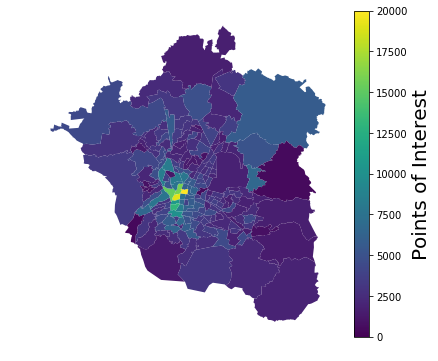

In [14]:
# Visualize Places of Interest

# Some Settings
vmin = 0
vmax = 20000
cmap = plt.cm.get_cmap('viridis')

fig,ax = plt.subplots()
gdf_dest.plot(column='dto_poi',cmap=cmap,ax=ax,vmin=vmin,vmax=vmax);
cbar = geopandas_colorbar_same_height(fig,ax,vmin,vmax,cmap)
cbar.ax.set_ylabel('Points of Interest', fontsize=20)
ax.axis('off')
plt.savefig('fig1b.svg')
plt.show()

Now, we plot the values of POIs and Trip Attraction to visualize and obtain the correlation between the two.

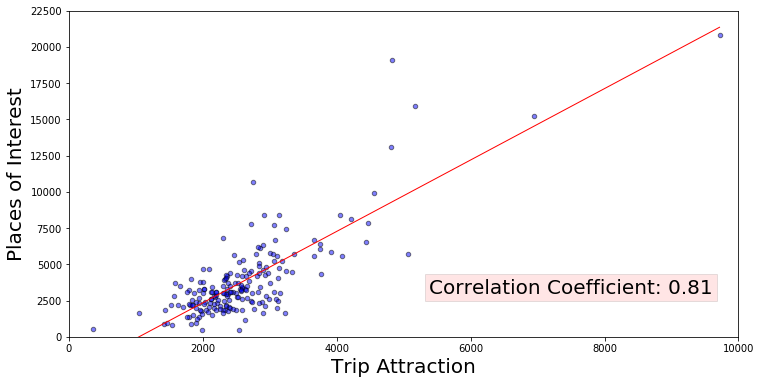

Correlation Coefficient: 0.8100130110714596


In [17]:
x = gdf_dest['dto_dest']
y = gdf_dest['dto_poi']
z = gdf_dest['population']
c = gdf_dest['sd_strat']

fig,ax = plt.subplots(figsize=(12,6))
ax.scatter(x,y,s=20,alpha=0.5,c='b',edgecolors='k')
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'r',linewidth=1)

# ax.set_title('Comparison of Trip Attraction and POIs for Each District', fontsize=16)
ax.set_xlabel('Trip Attraction', fontsize=20)
ax.set_ylabel('Places of Interest', fontsize=20)

ax.set_ylim(0,22500)
ax.set_xlim(0,10000)

# Label Prominent Districts
# for i, district in enumerate(gdf_dest['Distrito_int']):
#     if i in [0,1,7,15,14,8,50,33]:
#         ax.annotate(gdf_dest['Descripcio'][i], (x[i]+3, y[i]+0.0001),fontsize=18)
ax.text(7500,3000,'Correlation Coefficient: {0:.2g}'.format(np.corrcoef(x,y)[0,1]),
        fontsize=20,horizontalalignment='center',bbox=dict(facecolor='r', alpha=0.1))
plt.savefig('fig1c.svg')
plt.show()

print('Correlation Coefficient:',np.corrcoef(x,y)[0,1])

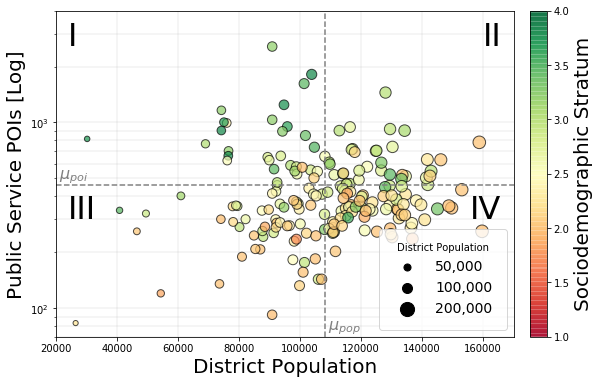

In [18]:
x = gdf_dest['population']
y = gdf_dest['dto_poi_pub']
z = gdf_dest['population']
c = gdf_dest['sd_strat']

xmin = 20000
xmax = 170000
ymin = 70
ymax = 4000
cmap = plt.cm.get_cmap('RdYlGn')

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
sc = ax.scatter(x,y,s=z/1000,c=c,alpha=0.7,cmap=cmap,edgecolors='k',zorder=2)
sc.set_clim([1,4])
cb = fig.colorbar(sc,pad=0.03)
cb.set_label('Sociodemographic Stratum',fontsize=20)

ax.set_yscale('log')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

# plt.title('Relationship of Public Service POIs with Population for each District', fontsize=16)
plt.xlabel('District Population', fontsize=20)
plt.ylabel('Public Service POIs [Log]', fontsize=20)
plt.grid(which='both',axis='both',linewidth=0.25,zorder=1)

l1 = plt.scatter([],[], s=50, edgecolors='k',facecolors='k')
l2 = plt.scatter([],[], s=100, edgecolors='k',facecolors='k')
l3 = plt.scatter([],[], s=200, edgecolors='k',facecolors='k')

labels = ["50,000", "100,000", "200,000"]

leg = plt.legend([l1, l2, l3],labels,ncol=1,frameon=True,fontsize=14,
                 loc=4,borderpad=1,handletextpad=1,title='District Population')

mean_color = [0.5,0.5,0.5]#'#0D4F8B'#'#3579DC'
ax.text(xmin + 0.05*xmin,np.mean(y),'$\mu_{poi}$',horizontalalignment='left',verticalalignment='bottom',color=mean_color,fontsize=16)
ax.text(np.mean(x) + 0.05*xmin,ymin,'$\mu_{pop}$',horizontalalignment='left',verticalalignment='bottom',color=mean_color,fontsize=16)
ax.hlines(np.mean(y),xmin=xmin,xmax=xmax,linestyle='--',color=mean_color)
ax.vlines(np.mean(x),ymin=ymin,ymax=ymax,linestyle='--',color=mean_color)

quadrant_color = 'k'#'#3579DC'
ax.text(xmin + 0.2*xmin,ymax-500,'I',fontsize=32, verticalalignment='top',color=quadrant_color)
ax.text(xmax - 0.2*xmin,ymax-500,'II',fontsize=32, verticalalignment='top',horizontalalignment='right',color=quadrant_color)
ax.text(xmin + 0.2*xmin,np.mean(y)-50,'III',fontsize=32, verticalalignment='top',color=quadrant_color)
ax.text(xmax - 0.2*xmin,np.mean(y)-50,'IV',fontsize=32, verticalalignment='top',horizontalalignment='right',color=quadrant_color)

plt.show()

Visualization for Deviance from Mean Public Service POIs per population.

### Save to a CSV File

In [13]:
# Keeping only the information needed, save to CSV Files

# POIs per District
district_poi = gdf_dest[['Distrito','Descripcio','dto_dest','dto_poi']]
district_poi.to_csv('district_poi.csv')

# List of all POIs
poi_df.to_csv('poi_list.csv')

In [13]:
gdf_dest.head()

,Distrito,Descripcio,geometry,Distrito_int,area,dto_dest,dto_dest_norm,dto_poi
0,001,Centro HistÃ³rico,POLYGON ((-99.13615639445072 19.44077855087982...,1,0.000480,9718,2.025620e+07,20812.0
1,002,Buenavista-Reforma,"POLYGON ((-99.1428980497852 19.46364494054671,...",2,0.000788,5177,6.572061e+06,15912.0
2,003,Tlatelolco,POLYGON ((-99.13141865172925 19.46378321641288...,3,0.000447,2861,6.405686e+06,6108.0
3,004,Morelos,POLYGON ((-99.10946106140032 19.45291794602026...,4,0.000540,3746,6.932684e+06,6056.0
4,005,"Moctezuma, Terminal de Autobuses de Oriente (T...",POLYGON ((-99.10055671090755 19.44982753391222...,5,0.000662,2903,4.385845e+06,6348.0


## POIs to a Grid

To simplify the process of percolation, rounding of the coordinates will be employed to three decimal points. This means the grid block size is approximately 100m x 100m.

In [771]:
poi_df['lat_grid'] = np.round(poi_df['lat'],decimals=2)
poi_df['lng_grid'] = np.round(poi_df['lng'],decimals=2)
poi_com_pub = poi_df.groupby(['lng_grid','lat_grid','category']).size().unstack(fill_value=0).reset_index()

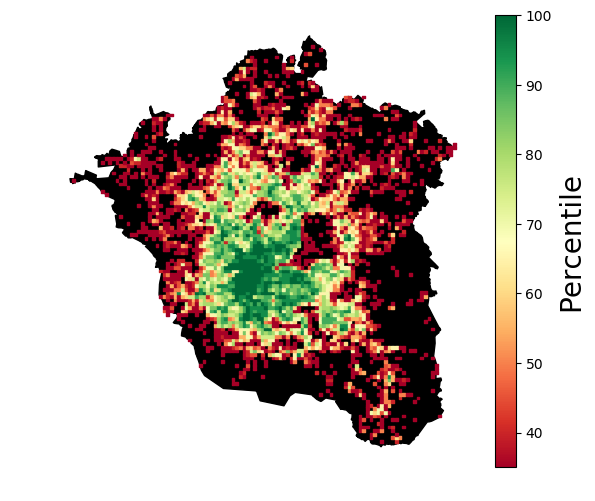

In [780]:
# Quick Visualization
c = (pd.qcut(poi_com_pub['public'], 20, labels=False,duplicates='drop') + 7)*5
cmap = plt.cm.get_cmap('RdYlGn')
vmin = min(c)
vmax = max(c)

fig = plt.figure()
ax = fig.gca()
gdf_dest.plot(color='k',ax=ax,edgecolor='k');

sc = ax.scatter(poi_com_pub['lng_grid'],poi_com_pub['lat_grid'],c=c,cmap=cmap,alpha=1,s=4,marker='s');
cbar = geopandas_colorbar_same_height(fig,ax,vmin,vmax,cmap)
cbar.ax.set_ylabel('Percentile', fontsize=20)

ax.axis('off')
# ax.set_title('Public Service POIs in the Metropolitan Zone of the Valley of Mexico')
plt.show()

In [396]:
poi_grid = pd.DataFrame(list(zip(np.round(poi_df['lng'],decimals=3),np.round(poi_df['lat'],decimals=3))),
                        columns=['lng','lat'])
poi_grid = poi_grid.groupby(['lng','lat']).size().reset_index(name='Count').sort_values(by=['Count'],axis=0,ascending=False)
poi_grid.head()

,lng,lat,Count
47405,-99.135,19.433,278
47408,-99.135,19.436,241
45316,-99.141,19.433,222
45314,-99.141,19.431,197
47041,-99.136,19.433,188


### Save to CSV File

In [106]:
# Save to CSV
poi_grid.to_csv('poi_grid.csv',header=False,index=False);